Retrospective target inference (RTI) approach from Beata's paper: 

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *
from click_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA

files          = glob.glob('D:/T5_ClosedLoop/historical/*')
click_sessions = get_Sessions(files, min_nblocks = 1, getClick = True)  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'Cursor y pos')

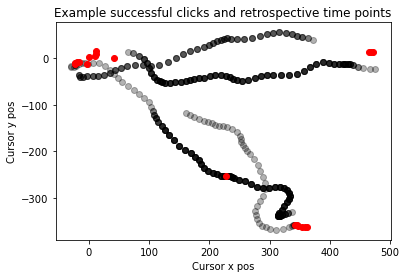

In [7]:
from RTI_utils import get_RTIData

session        = DataStruct(click_sessions[1], alignScreens = True)
clicks         = np.where(session.decClick_continuous == 1)[0]
start, stop    = clicks[120], clicks[140]

x, _, idxs     = get_RTIData(session.TX_continuous[start:stop, :], session.cursorPos_continuous[start:stop, :], session.decClick_continuous[start:stop],  
                             lookback = 60, MinDist = 20, MinTime = 15, ReturnInds = True)

plt.scatter(session.cursorPos_continuous[start + idxs, 0], session.cursorPos_continuous[start + idxs, 1], color = 'k', alpha = 0.3)
plt.scatter(session.cursorPos_continuous[clicks[120:140], 0], session.cursorPos_continuous[clicks[120:140], 1], color = 'r')
plt.title('Example successful clicks and retrospective time points')
plt.xlabel('Cursor x pos')
plt.ylabel('Cursor y pos')

In [8]:

lookback   = 60     # time points prior to consider 
MinDist    = 50
MinTime    = 15
train_frac = 0.5


session       = DataStruct(click_sessions[1], alignScreens = True)
session_len   = len(session.decClick_continuous)
n_train       = int(train_frac * session_len)


train_x        = session.TX_continuous[:n_train, :]
train_y        = (session.targetPos_continuous - session.cursorPos_continuous)[:n_train, :]
train_cursor   = session.cursorPos_continuous[:n_train, :]
train_click    = session.decClick_continuous[:n_train]

train_xRTI, train_yRTI = get_RTIData(train_x, train_cursor, train_click, lookback = lookback, MinDist = MinDist, MinTime = MinTime)
test_x                 = session.TX_continuous[n_train:, :]
test_y                 = (session.targetPos_continuous - session.cursorPos_continuous)[n_train:, :]

# supervised recalibration:
print('Supervised recal decoder: R2 = ', LinearRegression().fit(train_x, train_y).score(test_x, test_y))

# RTI approach:
print('RTI decoder: R2 = ', LinearRegression().fit(train_xRTI, train_yRTI).score(test_x, test_y))


Supervised recal decoder: R2 =  0.4497145217683413
RTI decoder: R2 =  0.4345692606978079
